# MNIST SVM Tuning

This project includes two improvements over the standard LinearSVC classifier in order to reduce compute times: ensemble learning (via bagging) and adaptive hyperparameter tuning (bayesian optimization). The BaggingClassifier randomly divvies our train dataset between multiple weak learners, helping to simultaneously reduce overfitting and enable parallelized training (3+ cores). By reducing the number of overall data points per model from 60000 down to 20000, models become less complex to fit and therefore less time-consuming to reach convergence.

With a leaner and faster model in mind, sights are next set on how hyperparameter optimization can be improved. Switching out brute force grid searching with the more refined bayesian methodology helps direct the search to the hyperparameter range most likely to contain a global minimum.

In [1]:
# modules import
import matplotlib.pyplot as plt
import numpy as np
import time
import zipfile
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

In [2]:
# downloading data
api = KaggleApi()
api.authenticate()
dataset = 'hojjatk/mnist-dataset'
fnames = ['t10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte', 'train-images.idx3-ubyte', \
    'train-labels.idx1-ubyte']

# download if doesn't exist, and unzip if zipped
for fn in fnames:
    if os.path.exists(fn) == False:
        api.dataset_download_file(dataset, file_name=fn, path='./')
    if os.path.exists(fn + '.zip'):
        with zipfile.ZipFile(fn + '.zip', 'r') as zipref:
            zipref.extractall('.', [fn])

In [3]:
# image loader function
def load_images(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset = 16)
    data = data.reshape(-1, 784)
    return data / np.float32(256)

# label loader function
import numpy as np

def load_labels(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset = 8)
    return data

In [4]:
# loading in data, labels
X_train = load_images(fnames[2])
y_train = load_labels(fnames[3])

X_test = load_images(fnames[0])
y_test = load_labels(fnames[1])

In [5]:
# shuffle
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

# minmax scale
mms = MinMaxScaler().fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

In [6]:
# parameter space
space = {'C': hp.loguniform('C', np.log(.01), np.log(1000))}

In [7]:
# function to push linear svc through bagging classifier
def bag_score(params):
    clf = BaggingClassifier(LinearSVC(**params, loss = 'hinge', max_iter = 5000), \
        max_samples = 20000, n_jobs = -1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return {'loss': -score, 'status': STATUS_OK, 'model': clf}

In [8]:
# C hyperparameter tuning (35 minutes on a 8C:16T CPU)
trials = Trials()
best = fmin(fn = bag_score, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
best

100%|██████████| 50/50 [31:48<00:00, 38.16s/trial, best loss: -0.9222]


{'C': 0.26073269313519376}

One note, my Hyperopt model is not currently checking values along a uniform distribution. My original run of this optimizer, using a uniform distribution between .001 and 1000, highlighted a trend of lower Cs correlating with better scores. On a subsequent run I switched my model to sample from a loguniform distribution so as to take advantage of this insight. In a sense, this became "optimized hyperparameter optimization" through my use of the initial run results to further refine my hyperparameter search space.

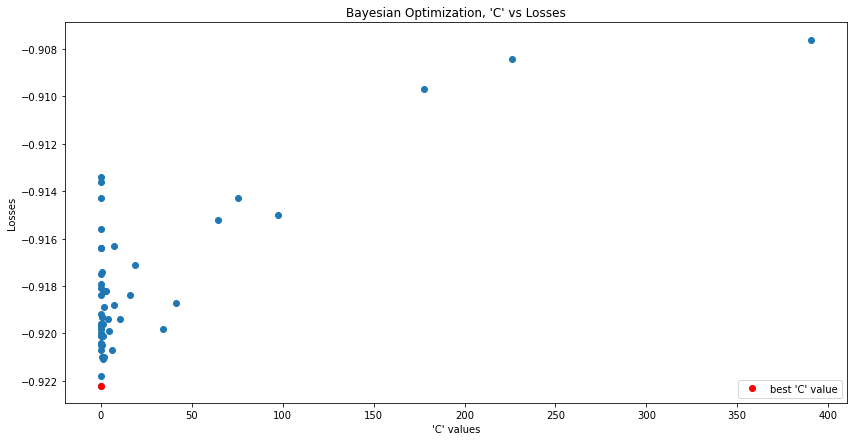

In [9]:
# visualization of the bayesian optimization
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.scatter(trials.vals['C'], trials.losses())
ax.plot(best['C'], trials.best_trial['result']['loss'], 'ro', label = 'best \'C\' value')
ax.legend(loc = 'lower right')
ax.set_xlabel('\'C\' values')
ax.set_ylabel('Losses')
ax.set_title('Bayesian Optimization, \'C\' vs Losses')
plt.show()

The above plot doesn't capture order of testing, see below for a plot of that. Note that the parameter converging to an optimal C is the result of:

    1. the hyperopt method normal use of bayes' theorem to track the loss function towards the global minimum
    2. the defining of my hyperparameter sample space to sample more from the lower C values
        

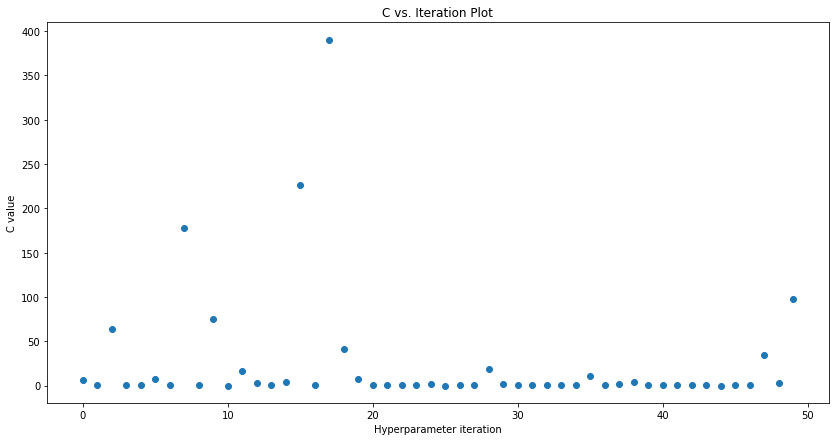

In [13]:
# order of tuning
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.scatter(range(len(trials.vals['C'])), trials.vals['C'])
ax.set_xlabel('Hyperparameter iteration')
ax.set_ylabel('C value')
ax.set_title('C vs. Iteration Plot')
plt.show()

In [17]:
# test error for a converging optimal model
t1 = time.time()
clf = BaggingClassifier(LinearSVC(C = best['C'], loss = 'hinge', max_iter = 5000), \
    max_samples = 20000, n_jobs = -1)
clf.fit(X_train, y_train)
t2 = time.time()
print(f'Fit time: {t2 - t1}')
print(f'Train error: {1.0 - clf.score(X_train, y_train)}')
print(f'Test error: {1.0 - clf.score(X_test, y_test)}')


Fit time: 11.684496641159058
Train error: 0.07678333333333331
Test error: 0.07909999999999995


In [25]:
# test error for a converging linearsvc model sans bagging, hyperparameter tuning
t1 = time.time()
clf = LinearSVC(loss = 'hinge', max_iter = 5000)
clf.fit(X_train, y_train)
t2 = time.time()
print(f'Fit time: {t2 - t1}')
print(f'Train error: {1.0 - clf.score(X_train, y_train)}')
print(f'Test error: {1.0 - clf.score(X_test, y_test)}')

Fit time: 23.647686004638672
Train error: 0.07025000000000003
Test error: 0.07830000000000004
/home/parkernisbet/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


A final remark on the results of this notebook, the optimal C value was only marginally better than pretty much all other alternatives; the worst C choice tested only saw a .014% drop in test accuracy. That said, the combination of bayesian optimization and bagging had a far more appreciable impact on resource usage. There is a bit more detailed description of this in the project README file, but grid searching a single LinearSVC model over the same number of Cs took 187 minutes. Some quick math puts this tradeoff at a 5.3x reduction in hyperparameter tuning time for a loss of 1.0 - 1.3% accuracy.